In [ ]:
!pip install matplotlib
!pip install deap
!pip install numpy

In [15]:

import math
import numpy as np
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import operator
import random
import numpy

from deap import base
from deap import benchmarks
from deap import creator
from deap import tools


Dibujar el hexagono que sera la region factible.

In [16]:


def Paint(ax):        
    
    Path = mpath.Path
    path_data = [
        (Path.MOVETO, (311.8,-16.3)),
        (Path.LINETO, (288.2,-16.3)),
        (Path.LINETO, (280.9, 6.2)),
        (Path.LINETO, (300,20.1)),
        (Path.LINETO, (319.1,6.2)),
        (Path.CLOSEPOLY, (311.8,-16.3)),
        ]
    codes, verts = zip(*path_data)
    path = mpath.Path(verts, codes)
    patch = mpatches.PathPatch(path, facecolor='r', alpha=0.5)
    ax.add_patch(patch)
    ax.axis('equal')



points =((311.8,-16.3), (288.2,-16.3), (280.9, 6.2), (300,20.1),(319.1,6.2))





Dibuja cada cuadrado y rectangulo valido dentro de la region factible.

In [17]:


def Paint_Q(List, VV, sizes, N, ax):
    Vx= VV[:N]
    Vy= VV[N:]
    for i in List:
        Paint_q(Vx[i],Vy[i],sizes[i], ax)
    

def Paint_q(vx,vy,s, ax):
    Path = mpath.Path
    #print(vx,vy)
    path_data = [
        (Path.MOVETO, (vx, vy)),
        (Path.LINETO, (vx, vy+s[1])),
        (Path.LINETO, (vx+s[0], vy+s[1])),
        (Path.LINETO, (vx+s[0], vy)),
        (Path.LINETO, (vx, vy)),
        (Path.CLOSEPOLY, (vx, vy)),
        ]
    codes, verts = zip(*path_data)
    path = mpath.Path(verts, codes)
    patch = mpatches.PathPatch(path, facecolor='b', alpha=0.5)
    ax.add_patch(patch)
    ax.axis('equal')




Valida que cada esquina del rectangulo o cuadrado esten dentro de la region factible para asegurar que toda su area este dentro de los limites establecidos en el problema.

In [18]:

def Into(P):
    distances = [math.sqrt((x-P[0])**2+ (y-P[1])**2) for (x,y) in points]
    num = list(zip(distances, range(len(distances))))
    num.sort()
    (x,y) =(num[0][1], num[1][1])
    #print(x,y, P)
    if P[1]<-16.3 or P[1]>319.1:
        return False
      
    if (x,y)==(1,2) or (x,y)==(2,1):
        x1= -P[1]/3.08219 +871.9876/3.08219
        if P[0]<x1:
            return False
    elif (x,y)==(2,3) or (x,y)==(3,2):
        x1= (P[1]+378609/1910)* 191/139
        if P[0]<x1:
            return False
    
    elif (x,y)==(3,4) or (x,y)==(4,3):
        x1= (P[1]-455391/1910)* (-191/139)
        if P[0]>x1:
            return False
        
    elif (x,y)== (4,0) or (x,y)==(0,4):
        x1= (P[1]+713449/730)* (73/225)
        if P[0]>x1 or P[0]<-16.3:
            return False
    elif (x,y)==(0,1) or (y,x)==(1,0) and P[0]<-16.3:
        return False
         
    else:
        return True
    return True


Elimina a las figuras con interposiciones.

In [20]:


def Inter(Vx, Vy, index, sizes):
    X=[(Vx[i],i) for i in index]+[(Vx[i]+sizes[i][0],i) for i in index]
    X.sort()
    L= np.array(X)[:,1]
    L_ind= set(range(len(L)))
    no_val=[]
    Total = []
    for i in range(len(L)):
        if i in L_ind and not( L[i] in no_val):
            
            l=L[i]
            j=i+1
            while  L[j]!=l:
                j+=1
            L_ind= L_ind-set([j])
           
            f= int(L[i])
            index_y= list(map(int, list(set(L[i+1:j]))))
            F = InterY(f, index_y,Vy, sizes)
            if F==[]:
                Total.append(L[i])
            else:
                no_val.extend(F)
           
    return list(map(int,Total))
            
            
            

def InterY(f, index_y,Vy, sizes):
    if index_y==[]:
        return []
    index_y.append(f)
    Y = [(Vy[k],k) for k in index_y]+[(Vy[k]+sizes[k][1],k) for k in index_y]
    Y.sort()
    
    L_y= [y[1] for y in Y]
    lim1 = L_y.index(f)
    lim2=  L_y[lim1+1:].index(f)+lim1+1
    J=  L_y[lim1+1: lim2]
    if J==[] and lim1>1:
       K=[]
       for h in L_y[:lim1]:
            lim1 = L_y.index(h)
            lim2=  L_y[lim1+1:].index(h)+lim1+1
            if f in L_y[lim1+1: lim2]:
                K.append(h)
       return K
    else:
        return  L_y[lim1+1: lim2]
        
          

Calculo del valor de aptitud. Area total cubierta por los rectangulos.

In [19]:

def Fitness(VV, sizes, N):
    Vx= VV[:N]
    Vy= VV[N:]
    index= []
    for i, vx, vy in zip(range(N), Vx, Vy):
        V= [vx, vy]
        #print(V)
        if Into(V)==True:
            p = sizes[i]
            one= [V[0]+p[0], V[1]]
            second= [V[0], V[1]+p[1]]
            third=[V[0]+p[0], V[1]+p[1]]
            c=0
            
            for v in [one, second, third]:
                if Into(v)== False:
                    break
                else:
                    c+=1
            if c==3:
                index.append(i)
       
    
    F= Inter(Vx, Vy, index, sizes)
    a= Area(F, sizes)
    #print(a)
    return a, F
    
    
    
def Area(List, sizes):
   A= [sizes[i][0]*sizes[i][1] for i in List]
   return sum(A)



**Algoritmo Genetico**

Parametros: numero de articulos, maximos y minimos permitidos para definir las posiciones de las esquinas izquierdas inferiores de cada rectangulo. 

In [21]:
Nitem = 50

Min= [280.9]*Nitem+[-16.3]*Nitem
Max= [319.1]*Nitem+[ 20.1]*Nitem



Crear funciones con Deap para PSO

In [22]:


creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Particle", list, fitness=creator.FitnessMax, speed=list, 
    smin=None, smax=None, best=None, elements=list)

def generate(size, pmin, pmax, smin, smax):
    part = creator.Particle(random.uniform(pmin[i], pmax[i]) for i in range(2*size)) 
    part.speed = [random.uniform(smin, smax) for _ in range(2*size)]
    part.smin = smin
    part.smax = smax
    return part



def updateParticle(part, best, phi1, phi2):
    #Genera dos vectores aleatorios con la misma longitud que la particula
    
    u1 = list(random.uniform(0, phi1) for _ in range(len(part)))
    u2 = list(random.uniform(0, phi2) for _ in range(len(part)))
    
    #Calcular nuevos factores de aprendizaje
    #v_u1=u1*(part.best-part)  part.best mejor valor de la particula
    v_u1 = map(operator.mul, u1, map(operator.sub, part.best, part))
    #v_u2=u2*(part.best-part)  part.best mejor valor a nivel global
    v_u2 = map(operator.mul, u2, map(operator.sub, best, part))
    #v(t)= v_u1+v_u2+ v(t-1)
    part.speed = list(map(operator.add, part.speed, map(operator.add, v_u1, v_u2)))
    
    
    for i, speed in enumerate(part.speed):
        
        if abs(speed) < part.smin:
            part.speed[i] = math.copysign(part.smin, speed)
            #copia psrt.smin cambiando su signo original por el de speed
        elif abs(speed) > part.smax:
            part.speed[i] = math.copysign(part.smax, speed)
        
    #Actualizar particula
    part[:] = list(map(operator.add, part, part.speed))

toolbox = base.Toolbox()
toolbox.register("particle", generate, size=Nitem, pmin=Max, pmax=Min, smin=-1, smax=1)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle, phi1=2, phi2=2)
toolbox.register("evaluate", Fitness)



/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Estructura general de PSO

In [23]:

#Problema de maximizacion enfoque global.
def main(Pops, sizes):
    pop = toolbox.population(n=Pops)
    GEN = 50
    best = None
    
    for g in range(GEN):
        print(g)
        for part in pop:
            apt, lis= Fitness(part, sizes, Nitem)
            part.fitness.values =(apt,)
            part.elements= lis
            
            if not part.best or part.best.fitness < part.fitness:
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
                part.best.elements = part.elements
                #Si la particula no tiene un mejor valor encontrado o si el mejor valor encontrado  es menor al  actual, entonces este es actualizado.
            if not best or best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values
                best.elements = part.elements
            #Si no hay ningun vector mejor o hay un vector que tiene mejores valores que el que se considera ser mejor, entonces se actualiza.
        #print(best.fitness.values, best.elements)
        for part in pop:
            toolbox.update(part, best)
            
        xx,yy=Fitness(best, sizes, Nitem)
        print(g, xx, len(yy))
       
    fig, ax = plt.subplots()
    Paint(ax)
    print("="*20)
    Paint_Q( best.elements, best, sizes, Nitem,ax)
    xx,yy=Fitness(best, sizes, Nitem)
    print(g, xx, len(yy))
    plt.title("Generation: "+ str(g+1) +   "    Area: "+ str(xx), size= 20)
    plt.xticks([])
    plt.yticks([])
    plt.show()
   
    return pop, best



Main para ejecuta el programa con una semilla en cero.

0
0 121 12
1
1 121 12
2
2 121 12
3
3 121 12
4
4 121 12
5
5 121 12
6
6 121 12
7
7 121 12
8
8 121 12
9
9 121 12
10
10 121 12
11
11 121 12
12
12 121 12
13
13 121 12
14
14 121 12
15
15 121 12
16
16 121 12
17
17 121 12
18
18 121 12
19
19 121 12
20
20 121 12
21
21 121 12
22
22 121 12
23
23 121 12
24
24 121 12
25
25 121 12
26
26 121 12
27
27 121 12
28
28 121 12
29
29 121 12
30
30 158 14
31
31 158 14
32
32 158 14
33
33 158 14
34
34 158 14
35
35 158 14
36
36 158 14
37
37 158 14
38
38 158 14
39
39 158 14
40
40 158 14
41
41 158 14
42
42 161 16
43
43 161 16
44
44 161 16
45
45 161 16
46
46 176 17
47
47 176 17
48
48 176 17
49
49 176 17
49 176 17


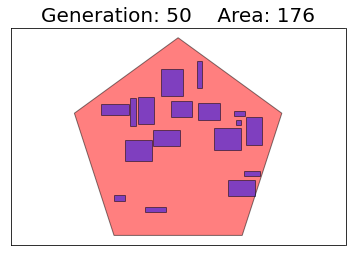

In [24]:


if __name__ == "__main__":
    random.seed(0)
    PopS = 100
    sizes = [[random.randrange(1, 6),random.randrange(1,6)] for _ in range(Nitem)]

    main(PopS, sizes)